# **Multivariate Climate Data Clustering using Deep Embedding Clustering (DEC) Model**
Here we are dealing with climate data that comprises spatial information, time information, and scientific values. The dataset contains the value of 7 parameters for a region of 41 longitudes and 41 latitudes for 365 days in a year. 

Our goal is to create meaningful clusters of 365 days based on the values of these 7 parameters. We have used the model suggested in the paper with the title "Unsupervised deep embedding for clustering analysis". 

Source: https://github.com/XifengGuo/DEC-keras/tree/2438070110b17b4fb9bc408c11d776fc1bd1bd56

##**1. Model Creation**

The Deep Embedding Clustering (DEC) model is created using 4 dense layers. After that, the output of these dense layers is provided to the clustering layer. To train the network the model used the KL divergence loss and Stochastic Gradient Descent (SGD). 

In [ ]:
from time import time
import numpy as np
import keras.backend as K
#from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
#import metrics


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if int(epochs/10) != 0 and epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    #print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|' % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: %ds' % round(time() - t0))
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = 500
        print('Save interval', save_interval)


        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                y_pred = q.argmax(1)
                print("#### inside iteration ### ", ite)
                if y is not None:
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, loss=loss)  
                    logwriter.writerow(logdict)
                    print('Iter %d: ' % (iter), ' ; loss=', loss)  

                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                print("##### Prediction in side the iter and the delta_label is ", delta_label)
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            print("#### the loss is ", loss)
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred

In [ ]:
!pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00


In [ ]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import datetime as dt
from netCDF4 import date2num,num2date
from math import sqrt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Data preparation**
The model takes one row for each data point. But our dataset size is 265x7x41x41. So we have transformed the data of one day from 7x41x41 to one row with 11767 columns. The dataset has some NaN values in the SST variable. To replace these NaN values we used the mean value of the full dataset. The function returns one NumPy array with size (365, 11767). 

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def data_preprocessing(data_path):
  rdata_daily = xr.open_dataset(data_path)    # data_path = '/content/drive/MyDrive/ERA5_Dataset.nc'
  rdata_daily_np_array = np.array(rdata_daily.to_array())   # the shape of the dailt data is (7, 365, 41, 41)
  rdata_daily_np_array_T = rdata_daily_np_array.transpose(1,0,2,3)   # transform the dailt data from (7, 365, 41, 41) to (365, 7, 41, 41)
  overall_mean = np.nanmean(rdata_daily_np_array_T[:, :, :, :])
  for i in range(rdata_daily_np_array_T.shape[0]):
    for j in range(rdata_daily_np_array_T.shape[1]):
      for k in range(rdata_daily_np_array_T.shape[2]):
        for l in range(rdata_daily_np_array_T.shape[3]):
          if np.isnan(rdata_daily_np_array_T[i, j, k, l]):
            #print("NAN data in ", i, j, k, l)
            rdata_daily_np_array_T[i, j, k, l] = overall_mean 
  rdata_daily_np_array_T_R = rdata_daily_np_array_T.reshape((rdata_daily_np_array_T.shape[0], -1))  # transform the dailt data from (365, 7, 41, 41) to (365, 11767)
  min_max_scaler = preprocessing.MinMaxScaler() # calling the function
  rdata_daily_np_array_T_R_nor = min_max_scaler.fit_transform(rdata_daily_np_array_T_R)   # now normalize the data, otherwise the loss will be very big 
  rdata_daily_np_array_T_R_nor = np.float32(rdata_daily_np_array_T_R_nor)    # convert the data type to float32, otherwise the loass will be out-of-limit 
  return rdata_daily_np_array_T_R_nor


In [ ]:
data_path = '/content/drive/MyDrive/ERA5_Dataset.nc'
data_nor = data_preprocessing(data_path)

In [ ]:
data_nor.shape

(365, 11767)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette_score1(X, labels, *, metric="cosine", sample_size=None, random_state=None, **kwds):  
 return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))

## **3. Model Training**
This function defines related parameters to train the model. Then instantiate the model and train on the pre-processed data. The model tries to optimize the clustering loss. After training the model returns the cluster results. 

In [ ]:
def main():
    # setting the hyper parameters

    batch_size = 128 
    maxiter = 2e4
    pretrain_epochs = 3
    update_interval = 30
    tol = 0.000001
    ae_weights = None
    save_dir = '/content/drive/MyDrive/DEC_result'

    # load dataset
    x = data_nor 
    y = None
    n_clusters = 7

    init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
    pretrain_optimizer = SGD(learning_rate=0.1, momentum=0.9)

    dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 150], n_clusters=n_clusters, init=init)

    if ae_weights is None:
        dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
                     epochs=pretrain_epochs, batch_size=batch_size,
                     save_dir=save_dir)
    else:
        dec.autoencoder.load_weights(ae_weights)

    dec.model.summary()
    t0 = time()
    dec.compile(optimizer=SGD(0.000001, 0.9), loss='kld')
    y_pred = dec.fit(x, y=y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                     update_interval=update_interval, save_dir=save_dir)
    print('clustering time: ', (time() - t0))
    return y_pred

In [ ]:
result = main()
result

array([3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 6, 6, 6, 1, 1, 1, 1, 1, 1,
       4, 4, 6, 6, 1, 4, 4, 1, 1, 4, 6, 6, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       4, 6, 6, 6, 3, 3, 3, 3, 1, 1, 6, 3, 1, 1, 1, 6, 6, 6, 1, 6, 6, 1,
       1, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 6, 6, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0,
       0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 5, 5, 5,

In [ ]:
silhouette_avg_rdata_daily = silhouette_score1(data_nor, result)
print("The average silhouette_score is :", silhouette_avg_rdata_daily)

The average silhouette_score is : 0.26557466


In [ ]:
from sklearn.metrics import davies_bouldin_score 

print("Davies-Bouldin score is ", davies_bouldin_score(data_nor, result))

Davies-Bouldin score is  1.6080024983219405


# **4. Model testing with pre-trained weights:**
To test the model on other datasets we have to create the model and initialize the model with pre-trained weights stored in the drive. Then we have to call the main function to get the clustering results.

In [ ]:
def main_test():
    # setting the hyper parameters

    batch_size = 128 
    maxiter = 2e4
    pretrain_epochs = 3
    update_interval = 30
    tol = 0.000001
    ae_weights = None
    save_dir = '/content/drive/MyDrive/DEC_result'

    # load dataset
    x = data_nor 
    y = None
    n_clusters = 7

    init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
    pretrain_optimizer = SGD(learning_rate=0.1, momentum=0.9)

    dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 150], n_clusters=n_clusters, init=init)


    dec.model.summary()
    dec.load_weights('/content/drive/MyDrive/DEC_result/DEC_model_final.h5')
    t0 = time()
    y_pred = dec.predict(x)
    print('clustering time: ', (time() - t0))
    return y_pred

In [ ]:
result = main_test()
result

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 11767)]           0         
                                                                 
 encoder_0 (Dense)           (None, 500)               5884000   
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 150)               300150    
                                                                 
 clustering (ClusteringLayer  (None, 7)                1050      
 )                                                               
                                                             

array([5, 3, 3, 3, 3, 6, 6, 5, 5, 5, 5, 4, 5, 5, 4, 5, 4, 4, 4, 4, 4, 5,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4,
       6, 6, 5, 5, 4, 6, 6, 4, 4, 6, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4,
       6, 5, 5, 5, 3, 3, 3, 3, 3, 5, 5, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 4,
       4, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,

# **5. Plotting the clustering results:**
To plot the clustering results first we have to create the model and initialize the model with pre-trained weights. Then we will create a new model by taking the Dense layer output and clustering output from the original model. The Dense layer output will be used to plot the clusters using the dimension reduction algorithm.

In [ ]:
n_clusters = 7

init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

dec = DEC(dims=[data_nor.shape[-1], 500, 500, 2000, 150], n_clusters=n_clusters, init=init)


dec.model.summary()
dec.load_weights('/content/drive/MyDrive/DEC_result/DEC_model_final.h5')

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 11767)]           0         
                                                                 
 encoder_0 (Dense)           (None, 500)               5884000   
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 150)               300150    
                                                                 
 clustering (ClusteringLayer  (None, 7)                1050      
 )                                                               
                                                           

In [ ]:
gradModel = Model(
			inputs=[dec.model.input],
			outputs=[dec.model.get_layer('encoder_3').output,
				dec.model.output])

In [ ]:
(convOutputs, predictions) = gradModel(data_nor)

Text(0, 0.5, 'Feature-2')

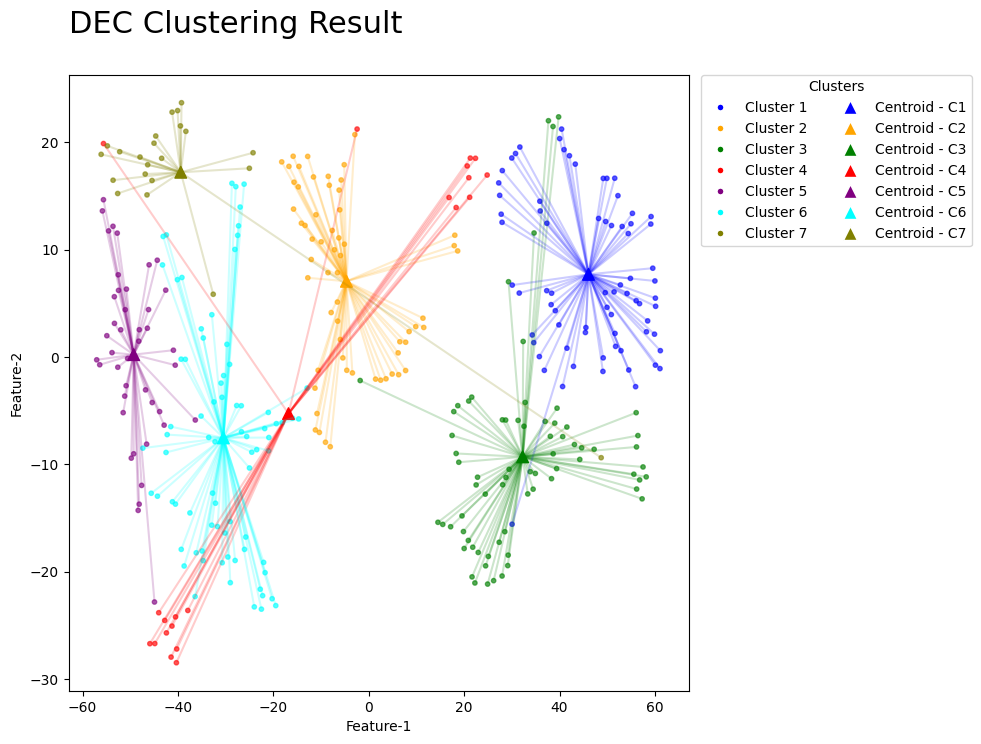

In [ ]:
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, learning_rate='auto', perplexity=10)
tsne_data = tsne.fit_transform(convOutputs)

tsne_df = pd.DataFrame(tsne_data, columns=['TSNE1','TSNE2'])
tsne_df['cluster'] = pd.Categorical(result)

Clusters = {}
Cluster_Centers = {}
for i in set(result):
    Clusters['Cluster' + str(i)] = np.array(tsne_df[tsne_df.cluster == i].drop(columns=['cluster']))
for i in range(len(Clusters)):
    Cluster_Centers[i] = np.mean(Clusters['Cluster' + str(i)],axis=0)

cen_x = [Cluster_Centers[i][0] for i in range(7)] 
cen_y = [Cluster_Centers[i][1] for i in range(7)]


tsne_df['cen_x'] = tsne_df.cluster.map({0:Cluster_Centers[0][0], 1:Cluster_Centers[1][0], 2:Cluster_Centers[2][0],
                                        3:Cluster_Centers[3][0], 4:Cluster_Centers[4][0], 5:Cluster_Centers[5][0],
                                        6:Cluster_Centers[6][0]})
tsne_df['cen_y'] = tsne_df.cluster.map({0:Cluster_Centers[0][1], 1:Cluster_Centers[1][1], 2:Cluster_Centers[2][1],
                                        3:Cluster_Centers[3][1], 4:Cluster_Centers[4][1], 5:Cluster_Centers[5][1],
                                        6:Cluster_Centers[6][1]})

colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'olive']
tsne_df['c'] = tsne_df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6]})

fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(tsne_df.TSNE1, tsne_df.TSNE2, c=tsne_df.c, alpha = 0.6, s=10,)
# plot centroids
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
# plot lines
for idx, val in tsne_df.iterrows():
    x = [val.TSNE1, val.cen_x,]
    y = [val.TSNE2, val.cen_y]
    plt.plot(x, y, c=val.c, alpha=0.2)
# legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
                   markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
legend_elements.extend([Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)])

plt.legend(handles=legend_elements, title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2, borderaxespad=0)

plt.title('DEC Clustering Result\n', loc='left', fontsize=22)
plt.xlabel('Feature-1')
plt.ylabel('Feature-2')

# **6. Evaluation:**
To compute the RMSE, variance, and average inter cluster distance we have to use the array format of our dataset and the clustering result.

In [ ]:
def total_rmse(data_path,formed_clusters):
  processed_data = data_preprocessing(data_path)
  trans_data = pd.DataFrame(processed_data)
  trans_data['Cluster'] = formed_clusters

  # Normalized
  # Function that creates two dictionaries that hold all the clusters and cluster centers
  def nor_get_clusters_and_centers(input,formed_clusters):
    Clusters = {}
    Cluster_Centers = {}
    for i in set(formed_clusters):
      Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
      Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    return Clusters,Cluster_Centers

  intra_rmse = []
  sq_diff = []
  Clusters,Cluster_Centers = nor_get_clusters_and_centers(trans_data,formed_clusters)
  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff)**2
      sq_diff.append(Sq_diff)

  Sq_diff_sum = np.sum(np.sum(sq_diff))
  rmse = np.sqrt(Sq_diff_sum/data_nor_eval.shape[0])
  return rmse

In [ ]:
total_rmse('/content/data/ERA5_Dataset.nc', result)

13.62852527582571

### This cell measure the variances of the generated clusters.  

In [ ]:
trans_data = pd.DataFrame(data_nor)
trans_data['Cluster'] = result
Clusters = {}
Cluster_Centers = {}
for i in set(result):
  Clusters['Cluster' + str(i)] = np.array(trans_data[trans_data.Cluster == i].drop(columns=['Cluster']))

variances = pd.DataFrame(columns=range(len(Clusters)),index=range(2))
for i in range(len(Clusters)):
    variances[i].iloc[0] = np.var(Clusters['Cluster' + str(i)])
    variances[i].iloc[1] = Clusters['Cluster' + str(i)].shape[0]

var_sum = 0
for i in range(7):
    var_sum = var_sum + (variances[i].iloc[0] * variances[i].iloc[1])

var_avg = var_sum/data_nor_eval.shape[0]
var_avg

0.04486383661869212

### The following cell measure the average inter cluster distance.  

In [ ]:
from scipy.spatial.distance import cdist,pdist

trans_data = pd.DataFrame(data_nor)
trans_data['Cluster'] = result
Clusters = {}
Cluster_Centers = {}
for i in set(result):
  Clusters['Cluster' + str(i)] = np.array(trans_data[trans_data.Cluster == i].drop(columns=['Cluster']))

distance_matrix = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
for i in range(len(Clusters)):
  for j in range(len(Clusters)):
    if i == j:
      #distance_matrix[i].iloc[j] = 0
      distance_intra = cdist(Clusters['Cluster' + str(i)], Clusters['Cluster' + str(j)], 'euclidean')
      distance_matrix[i].iloc[j] = np.max(distance_intra)
    elif i > j:
       continue
    else:
      distance = cdist(Clusters['Cluster' + str(i)], Clusters['Cluster' + str(j)], 'euclidean')
      distance_matrix[i].iloc[j] = np.min(distance)
      distance_matrix[j].iloc[i] = np.min(distance)

sum_min = 0
for i in range(n_clusters):
    sum_min = sum_min + np.min(distance_matrix[i])

avg_inter = sum_min/n_clusters
avg_inter

6.754513334091358